# Wheather forcasting tool

In [2]:
!mkdir -p ~/.kaggle

!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d muthuj7/weather-dataset

Dataset URL: https://www.kaggle.com/datasets/muthuj7/weather-dataset
License(s): CC0-1.0
  0% 0.00/2.23M [00:00<?, ?B/s]
100% 2.23M/2.23M [00:00<00:00, 143MB/s]


# Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt


In [5]:
import zipfile

# Specify the path to the zip file
zip_file_path = '/content/weather-dataset.zip'

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')
    print("Zip file extracted successfully.")

Zip file extracted successfully.


In [8]:
# Convert 'Formatted Date' to datetime
data['Formatted Date'] = pd.to_datetime(data['Formatted Date'])

# Drop columns that won't be used for prediction
data = data.drop(['Formatted Date', 'Summary', 'Daily Summary'], axis=1)

# Handle missing values
data.fillna(method='ffill', inplace=True)

# Encode categorical features (like 'Precip Type')
data = pd.get_dummies(data, columns=['Precip Type'], drop_first=True)

# Normalize or scale the data if needed
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Convert back to DataFrame
data_scaled = pd.DataFrame(data_scaled, columns=data.columns)


<ipython-input-8-5a17198d053b>:2: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  data['Formatted Date'] = pd.to_datetime(data['Formatted Date'])
<ipython-input-8-5a17198d053b>:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [9]:
def create_features(df, lags, target_column):
    for lag in range(1, lags+1):
        df[f'{target_column}_lag_{lag}'] = df[target_column].shift(lag)
    df.dropna(inplace=True)
    return df

data_scaled = create_features(data_scaled, lags=3, target_column='Temperature (C)')


In [10]:
X = data_scaled.drop(['Temperature (C)'], axis=1)
y = data_scaled['Temperature (C)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Train Random Forest

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Initialize the model
rf_model = RandomForestRegressor()

# Train the model
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test)
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("Random Forest MAE:", mean_absolute_error(y_test, y_pred_rf))
print("Random Forest R²:", r2_score(y_test, y_pred_rf))


Random Forest RMSE: 0.0021920722205088492
Random Forest MAE: 0.0004794995539382555
Random Forest R²: 0.9997990390639462


# Train the LSTM

In [14]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Reshape data for LSTM
X_train_lstm = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], 1)))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=32, validation_data=(X_test_lstm, y_test))

# Predict and evaluate
y_pred_lstm = lstm_model.predict(X_test_lstm)
print("LSTM RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lstm)))
print("LSTM MAE:", mean_absolute_error(y_test, y_pred_lstm))
print("LSTM R²:", r2_score(y_test, y_pred_lstm))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 0.0203 - val_loss: 0.0018
Epoch 2/10
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - loss: 0.0010 - val_loss: 1.5784e-04
Epoch 3/10
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 1.8061e-04 - val_loss: 1.4830e-04
Epoch 4/10
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 1.3548e-04 - val_loss: 1.0752e-04
Epoch 5/10
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step - loss: 1.2217e-04 - val_loss: 1.2052e-04
Epoch 6/10
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 1.1364e-04 - val_loss: 7.5801e-05
Epoch 7/10
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 9.9036e-05 - val_loss: 7.5200e-05
Epoch 8/10
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 8.9029e-05 - val_loss: 6.6391e-05
Epoch 9/10
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 6.6013e-05 - val_loss: 5.2587e-05
Epoch 10/10
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 6.1858e-05 - val_loss: 8.4466e-05
603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/ste

# Show through Graph

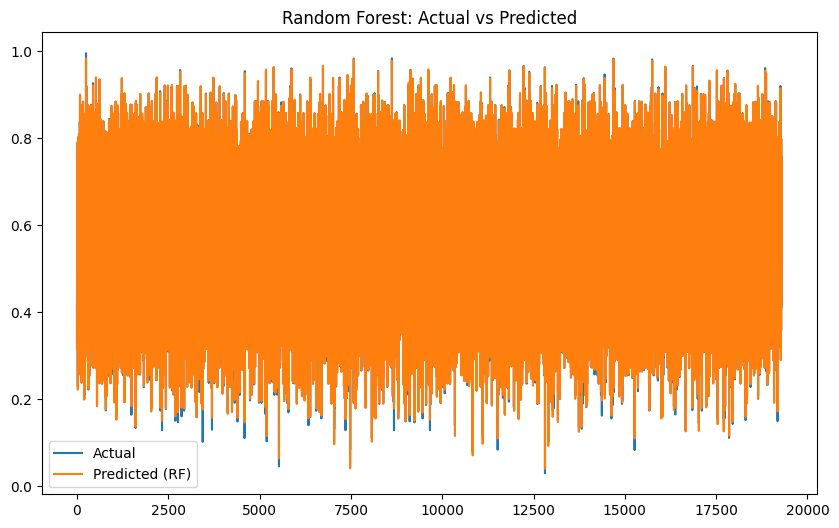

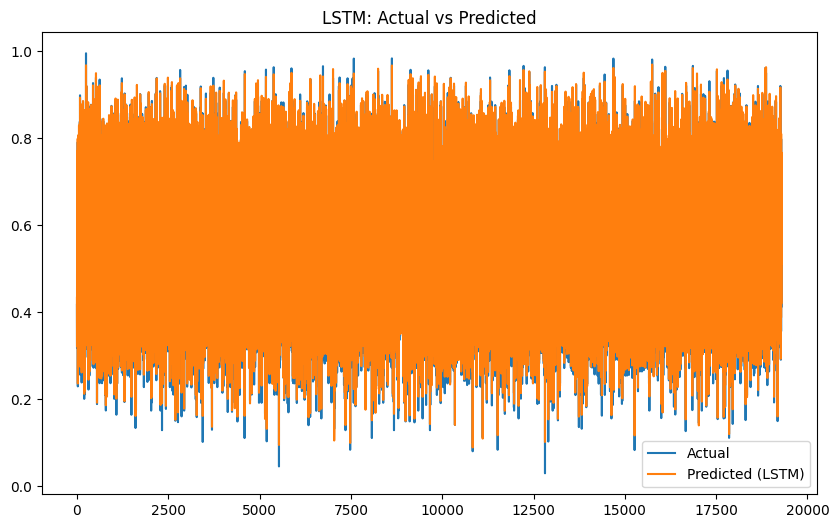

In [15]:
import matplotlib.pyplot as plt

# Plot actual vs predicted values for Random Forest
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred_rf, label='Predicted (RF)')
plt.title('Random Forest: Actual vs Predicted')
plt.legend()
plt.show()

# Plot actual vs predicted values for LSTM
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred_lstm, label='Predicted (LSTM)')
plt.title('LSTM: Actual vs Predicted')
plt.legend()
plt.show()
